# A first analysis of the Galactic Center
In this tutorial, we will examine the basic elements of an Analysis.  The main object we will manipulate is the Analysis class, which contains a variety of helper functions to simplify adding, removing, and manipulating the templates we want to fit, as well as the fit masks, and some basic visualization of results.  

The methods in GammaLike are fully documented.  In ipython/jupyter notebooks you can use shift+tab to view the docstring of a function. 



First, let's load the anlaysis from the previous tutorial. 

In [3]:
import sys
sys.path.append('/data/GammaLike/')
from GammaLike import Analysis

basepath = '/data/GammaLike/testing/'
tag = 'P8R2_CLEAN_V6_calore' 
A = Analysis.Load(basepath+tag+'.GLanalysis')

# Adding the Fermi diffuse model template

For now we will just use the Fermi diffuse model.  Later we will learn how to use Galprop's output to construct our own diffuse model.  The Fermi template contains the $\pi^0$, ICS, and bremstrahlung contributions of the Galactic diffuse emission.  For diffuse analysis in the Galactic plane, this is not the best to use since it is optimized for point source analysis.  Beyond the Pass 6 models, these also contain Fermi Bubbles, Loop 1, and empirical corrections for bright ICS regions. 

We can simply add the diffuse model to the analysis by calling Analysis.AddFermiDiffuseModel() which will convert the Fermi model to the healpix grid and convolve it with the IRFs. 

In [5]:
A.AddFermiDiffuseModel(diffuse_path='/data/fermi_background_models/gll_iem_v06.fits',  # This is the Pass 8 diffuse model.
                       infile=None,       # Won't use this for now, but we can load the result by specifying infile
                       # Store the result by specifying outfile.  
                       # We will need this below to calculate point source masks.
                       outfile=A.basepath+'/'+'fermi_diffuse_'+A.tag+'.npy',
                       fixSpectrum=False) # Allow the spectrum to float in each energy bin. 

Remapping Fermi Diffuse Model to Healpix Grid 100.00 % 24


Now we need to also add the isotropic gamma-ray background template.  We need to specify a flux and flux uncertainty for the default values, and the template is then pnealized according to the external $\chi^2$ prescription of http://arxiv.org/abs/1409.0042 Eq. (2.5).

In [4]:
A.AddIsotropicTemplate(
        isofile='/data/GCE_sys/IGRB_ackerman_2014_modA.dat', # See the appendix at the bottom of the file. 
        fixNorm=False, fixSpectrum=False) 

24


We would also like to add the fixed point source template which we already generated. We also need to mask the point sources.  GammaCAP uses the adaptive masking scheme of http://arxiv.org/abs/1409.0042 Eq. (2.6)

In [17]:
A.AddPointSourceTemplate(fixNorm=True, # Fix the template normalization in all bins.
                         pscmap=A.basepath + '/PSC_' + A.tag + '_fgl3_with_ext.npy') # This was generated in the first tutorial

A.CalculatePixelWeights(diffuse_model=A.basepath+'/'+'fermi_diffuse_'+A.tag+'.npy',
                        psc_model=A.basepath + '/PSC_' + A.tag + '_fgl3_with_ext.npy',
                        alpha_psc=5., f_psc=0.1) # see 1409.0042 Eq.(2.6)


Normally we would also add the Fermi Bubbles template, but this is already included in the Fermi background model.  We will see in later tutorials how to add this component. 

# Masking and choosing the ROI

GammaLike includes easy tools for masking and choosing the ROI, and one can specify arbitrary weights to each pixel.  More complex masking routines will be shown later and allow us to split templates into rings or subregions, for example.   Here we will reproduce the Calore 2015 analysis window over the inner Galaxy.  This is a square window centered on the Galactic Center running from +20 to -20 in lat/lon, with the plane $|b|<2^\circ$ masked out. 

In [20]:
_ =A.GenSquareMask(l_range=[-20.,20.], b_range=[-20.,20.], plane_mask=2.)

# Adding a dark matter template

We can now generate a dark matter template and add it to the fit. Let's start with an NFW profile with inner slope $\alpha=1.25$

In [23]:
_ = A.AddDMTemplate(profile='NFW', # Can be 'Ein', 'NFW', or 'Bur'
                limits=[None,None], 
                decay=False,     # Annihilation or decay? 
                gamma=1.25,      # Inner Slope
                r_s=20.0,        # NFW Scale radius 
                axesratio=1,     # Can skew the projected profile 
                offset=(0, 0),   # Can offset the profile 
                spec_file=None,) # Can specify a spectrum if we want 

Now we can look at the templates which are included in the fit via A.PrintTemplates().  

The output tells us the fitting specifications of each template.  SRCCLASS is used internally, so disregard this at the moment. 

In [24]:
A.PrintTemplates()

                NAME                    LIMITS      VALUE    FIXNORM    FIXSPEC   SRCCLASS
                 PSC              [None, None]  1.000e+00       True       True        PSC
                  DM              [None, None]  1.000e+00      False      False        GEN
        FermiDiffuse              [None, None]  1.000e+00      False      False        GEN
           Isotropic              [None, None]  1.000e+00      False      False        ISO


# Visualize the Templates. 

Let's use healpy to plot our templates over the ROI. We can access the template objects directly for lower level control.  See the docs for more information on this. 

-c:5: RuntimeWarning: invalid value encountered in log10


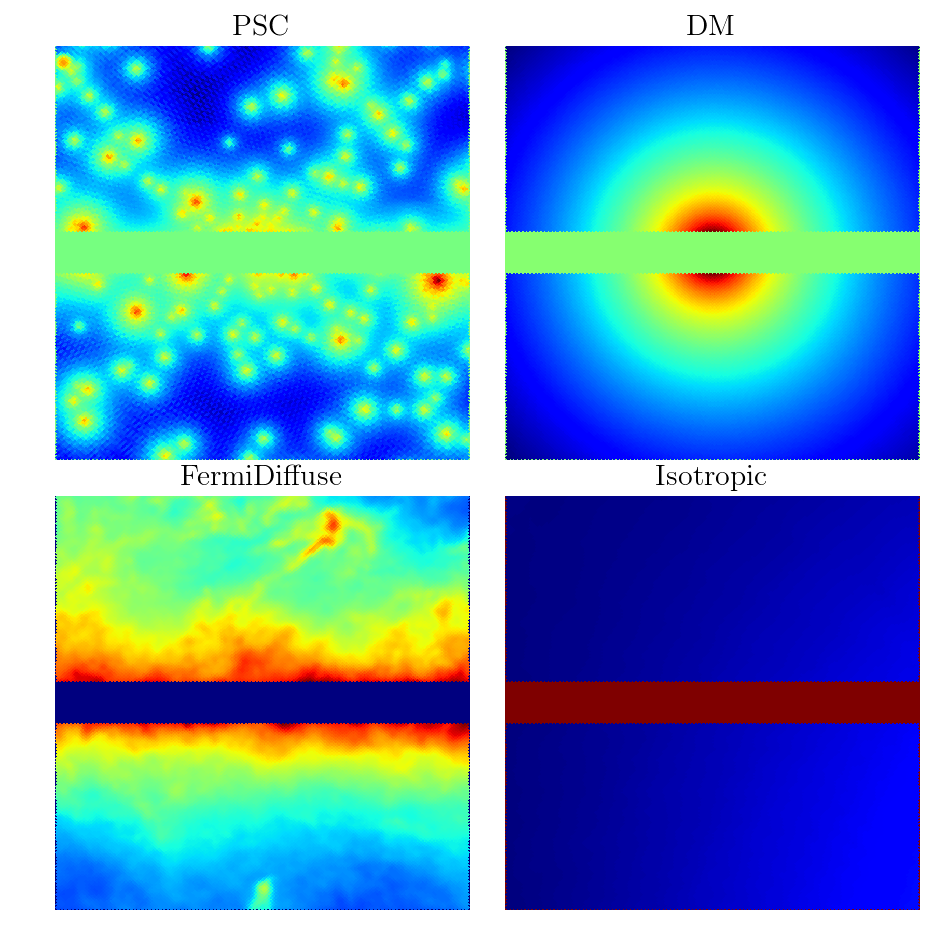

In [34]:
import healpy 

plt.figure(figsize=(6,6))
for i, (key, t) in enumerate(A.templateList.items()):
    healpy.cartview(np.log10(t.healpixCube[10])*A.mask, # just picking the 10th energy bin. Masking is applied in fitting only
                    lonra=(-20,20), latra=(-20,20), 
                    title=key,
                    sub=(2,2,i+1), 
                    cbar=False)

# Running the Fit.

Now we load our binned photon data and run the fit in each energy bin. The output is very long, but should be readable.  The normalization and errors are in the input template units.  Fit convergence is improved if these are normalized similarly. For some models, you may need to play with  limits on each template to get convergence.

In [37]:
A.BinPhotons(infile='binned_photons_'+A.tag+'.npy')
A.RunLikelihood(print_level=1)

Masking completed in 1.5890e-01 s
Write likelihood tempfile to  /tmp/tmpOGy14V
Code generation completed in 1.1802e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -603084.546285 
 TOTAL NCALL = 50 
 NCALLS = 50 
 
 
 EDM = 1.12125016265e-07 
 GOAL EDM = 0.005 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_0,2.223055e-01,7.538997e-02,0.000000e+00,0.000000e+00,,,
3,FermiDiffuse_0,1.122960e+00,4.759082e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_0,-3.542919e-01,5.879714e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   6.98e-02 s
Masking completed in 1.0245e-01 s
Write likelihood tempfile to  /tmp/tmp845y5n
Code generation completed in 9.8610e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -476535.759586 
 TOTAL NCALL = 43 
 NCALLS = 43 
 
 
 EDM = 0.000173533029826 
 GOAL EDM = 0.005 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_1,1.269709e-01,8.798891e-02,0.000000e+00,0.000000e+00,,,
3,FermiDiffuse_1,1.124590e+00,4.953048e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_1,-3.795965e-01,6.385963e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   4.91e-02 s
Masking completed in 9.9789e-02 s
Write likelihood tempfile to  /tmp/tmpHCJIAm
Code generation completed in 9.7013e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -374175.090826 
 TOTAL NCALL = 45 
 NCALLS = 45 
 
 
 EDM = 2.59285817643e-07 
 GOAL EDM = 0.005 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_2,1.996855e-01,9.611758e-02,0.000000e+00,0.000000e+00,,,
3,FermiDiffuse_2,1.088245e+00,5.064713e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_2,-3.712633e-01,6.875399e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   5.11e-02 s
Masking completed in 1.0006e-01 s
Write likelihood tempfile to  /tmp/tmpOEO8a9
Code generation completed in 9.7895e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -286384.749961 
 TOTAL NCALL = 45 
 NCALLS = 45 
 
 
 EDM = 6.68078224942e-08 
 GOAL EDM = 0.005 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_3,2.315388e-01,9.480473e-02,0.000000e+00,0.000000e+00,,,
3,FermiDiffuse_3,1.061665e+00,5.296543e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_3,-2.749689e-01,7.371986e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   5.12e-02 s
Masking completed in 9.8718e-02 s
Write likelihood tempfile to  /tmp/tmpPZBP6b
Code generation completed in 9.7108e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -276183.469342 
 TOTAL NCALL = 46 
 NCALLS = 46 
 
 
 EDM = 1.26880365915e-06 
 GOAL EDM = 0.005 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_4,1.818669e-01,1.044002e-01,0.000000e+00,0.000000e+00,,,
3,FermiDiffuse_4,1.065721e+00,5.287451e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_4,-1.208345e-01,7.193376e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   5.24e-02 s
Masking completed in 1.0055e-01 s
Write likelihood tempfile to  /tmp/tmpy3l04B
Code generation completed in 9.9683e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -274328.236886 
 TOTAL NCALL = 45 
 NCALLS = 45 
 
 
 EDM = 5.19601074456e-06 
 GOAL EDM = 0.005 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_5,2.700828e-01,7.163862e-02,0.000000e+00,0.000000e+00,,,
3,FermiDiffuse_5,1.024957e+00,5.007639e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_5,-1.955617e-01,6.850675e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   5.14e-02 s
Masking completed in 9.9568e-02 s
Write likelihood tempfile to  /tmp/tmpNBh6EB
Code generation completed in 9.7084e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -263804.332749 
 TOTAL NCALL = 45 
 NCALLS = 45 
 
 
 EDM = 7.62042529043e-06 
 GOAL EDM = 0.005 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_6,1.058087e-01,8.275168e-02,0.000000e+00,0.000000e+00,,,
3,FermiDiffuse_6,1.011230e+00,4.865948e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_6,-6.671788e-02,6.503947e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   5.15e-02 s
Masking completed in 9.9934e-02 s
Write likelihood tempfile to  /tmp/tmpPFMidb
Code generation completed in 9.4318e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -245310.38468 
 TOTAL NCALL = 45 
 NCALLS = 45 
 
 
 EDM = 5.21702506119e-07 
 GOAL EDM = 0.005 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_7,1.652952e-01,6.717899e-02,0.000000e+00,0.000000e+00,,,
3,FermiDiffuse_7,9.992693e-01,4.876611e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_7,8.875466e-02,6.632462e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   5.15e-02 s
Masking completed in 9.9606e-02 s
Write likelihood tempfile to  /tmp/tmpsayH9U
Code generation completed in 9.4795e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -230737.627008 
 TOTAL NCALL = 45 
 NCALLS = 45 
 
 
 EDM = 1.65366466122e-07 
 GOAL EDM = 0.005 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_8,1.581256e-01,6.980779e-02,0.000000e+00,0.000000e+00,,,
3,FermiDiffuse_8,9.701875e-01,4.734978e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_8,8.023737e-02,6.843250e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   5.16e-02 s
Masking completed in 9.9748e-02 s
Write likelihood tempfile to  /tmp/tmpRQaccF
Code generation completed in 1.0021e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -206941.267378 
 TOTAL NCALL = 46 
 NCALLS = 46 
 
 
 EDM = 2.41182851736e-06 
 GOAL EDM = 0.005 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_9,4.750856e-02,6.595927e-02,0.000000e+00,0.000000e+00,,,
3,FermiDiffuse_9,9.823789e-01,4.876749e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_9,1.641705e-01,7.100837e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   5.26e-02 s
Masking completed in 9.9888e-02 s
Write likelihood tempfile to  /tmp/tmpuh43U_
Code generation completed in 9.4914e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -189146.664826 
 TOTAL NCALL = 46 
 NCALLS = 46 
 
 
 EDM = 2.270551504e-07 
 GOAL EDM = 0.005 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_10,1.890106e-01,5.180308e-02,0.000000e+00,0.000000e+00,,,
3,FermiDiffuse_10,9.516245e-01,4.819958e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_10,2.808212e-01,7.573823e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   5.25e-02 s
Masking completed in 9.9456e-02 s
Write likelihood tempfile to  /tmp/tmplJWg2h
Code generation completed in 9.7704e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -155414.604176 
 TOTAL NCALL = 45 
 NCALLS = 45 
 
 
 EDM = 1.22781634674e-06 
 GOAL EDM = 0.005 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_11,1.493178e-01,4.926686e-02,0.000000e+00,0.000000e+00,,,
3,FermiDiffuse_11,9.839677e-01,5.189236e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_11,3.622731e-01,8.189684e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   5.14e-02 s
Masking completed in 9.9039e-02 s
Write likelihood tempfile to  /tmp/tmpX6Ngwt
Code generation completed in 9.6989e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -122946.61236 
 TOTAL NCALL = 39 
 NCALLS = 39 
 
 
 EDM = 0.00230305973006 
 GOAL EDM = 0.005 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_12,8.410967e-02,5.163126e-02,0.000000e+00,0.000000e+00,,,
3,FermiDiffuse_12,9.465704e-01,5.250150e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_12,4.899186e-01,8.890604e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   4.49e-02 s
Masking completed in 1.0013e-01 s
Write likelihood tempfile to  /tmp/tmpdTnJYU
Code generation completed in 9.6488e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -89293.138662 
 TOTAL NCALL = 39 
 NCALLS = 39 
 
 
 EDM = 0.00016434963287 
 GOAL EDM = 0.005 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_13,1.749751e-01,4.720495e-02,0.000000e+00,0.000000e+00,,,
3,FermiDiffuse_13,9.420461e-01,5.602599e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_13,5.221100e-01,9.547654e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   4.52e-02 s
Masking completed in 9.9881e-02 s
Write likelihood tempfile to  /tmp/tmp3TvOKw
Code generation completed in 9.5582e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -61495.0766863 
 TOTAL NCALL = 43 
 NCALLS = 43 
 
 
 EDM = 1.19453053648e-06 
 GOAL EDM = 0.005 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_14,2.721860e-02,5.134867e-02,0.000000e+00,0.000000e+00,,,
3,FermiDiffuse_14,9.491225e-01,5.824749e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_14,4.885624e-01,9.164239e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   4.96e-02 s
Masking completed in 9.9582e-02 s
Write likelihood tempfile to  /tmp/tmpvmh8Cg
Code generation completed in 9.6703e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -33485.5928921 
 TOTAL NCALL = 44 
 NCALLS = 44 
 
 
 EDM = 1.04424623364e-07 
 GOAL EDM = 0.005 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_15,1.738561e-01,4.830452e-02,0.000000e+00,0.000000e+00,,,
3,FermiDiffuse_15,9.213787e-01,6.246910e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_15,7.492539e-01,9.168367e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   5.06e-02 s
Masking completed in 1.0019e-01 s
Write likelihood tempfile to  /tmp/tmp1Cwmsi
Code generation completed in 9.6393e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -10938.6624026 
 TOTAL NCALL = 41 
 NCALLS = 41 
 
 
 EDM = 3.32242061157e-08 
 GOAL EDM = 0.005 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_16,2.161966e-01,4.880478e-02,0.000000e+00,0.000000e+00,,,
3,FermiDiffuse_16,9.513062e-01,7.343219e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_16,8.933589e-01,1.061494e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   4.72e-02 s
Masking completed in 9.9501e-02 s
Write likelihood tempfile to  /tmp/tmpbyXTO0
Code generation completed in 9.4795e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 6917.62049943 
 TOTAL NCALL = 39 
 NCALLS = 39 
 
 
 EDM = 6.1735227636e-06 
 GOAL EDM = 0.005 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_17,1.654713e-01,5.785185e-02,0.000000e+00,0.000000e+00,,,
3,FermiDiffuse_17,9.774026e-01,8.824561e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_17,1.135578e+00,1.246308e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   4.51e-02 s
Masking completed in 9.9829e-02 s
Write likelihood tempfile to  /tmp/tmpxR9qLO
Code generation completed in 9.8920e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 16955.2251129 
 TOTAL NCALL = 39 
 NCALLS = 39 
 
 
 EDM = 9.84729208913e-07 
 GOAL EDM = 0.005 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_18,-1.084356e-01,8.103404e-02,0.000000e+00,0.000000e+00,,,
3,FermiDiffuse_18,1.042547e+00,1.075815e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_18,1.313925e+00,1.297685e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   4.49e-02 s
Masking completed in 9.9015e-02 s
Write likelihood tempfile to  /tmp/tmpksBUlq
Code generation completed in 9.5797e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 21381.4396667 
 TOTAL NCALL = 37 
 NCALLS = 37 
 
 
 EDM = 0.000151053693667 
 GOAL EDM = 0.005 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_19,-3.689542e-02,7.966765e-02,0.000000e+00,0.000000e+00,,,
3,FermiDiffuse_19,1.107296e+00,1.392225e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_19,1.464478e+00,1.172808e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   4.31e-02 s
Masking completed in 9.9266e-02 s
Write likelihood tempfile to  /tmp/tmpcl49fv
Code generation completed in 9.6011e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 21311.8714882 
 TOTAL NCALL = 37 
 NCALLS = 37 
 
 
 EDM = 7.14923001499e-06 
 GOAL EDM = 0.005 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_20,-6.531128e-01,1.642660e-01,0.000000e+00,0.000000e+00,,,
3,FermiDiffuse_20,1.234694e+00,1.844065e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_20,1.560516e+00,1.180219e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   4.32e-02 s
Masking completed in 9.9710e-02 s
Write likelihood tempfile to  /tmp/tmpWv0xUa
Code generation completed in 9.6798e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 17326.4370232 
 TOTAL NCALL = 33 
 NCALLS = 33 
 
 
 EDM = 0.000693673668098 
 GOAL EDM = 0.005 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_21,-2.336221e-01,1.514404e-01,0.000000e+00,0.000000e+00,,,
3,FermiDiffuse_21,1.278721e+00,2.631654e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_21,1.457621e+00,1.143248e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   3.89e-02 s
Masking completed in 9.9209e-02 s
Write likelihood tempfile to  /tmp/tmpYtcV9r
Code generation completed in 9.6512e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 10978.8365861 
 TOTAL NCALL = 33 
 NCALLS = 33 
 
 
 EDM = 7.16374212345e-05 
 GOAL EDM = 0.005 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_22,-3.776470e-01,2.086618e-01,0.000000e+00,0.000000e+00,,,
3,FermiDiffuse_22,1.384405e+00,3.956460e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_22,1.166737e+00,1.207523e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   3.91e-02 s
Masking completed in 9.9791e-02 s
Write likelihood tempfile to  /tmp/tmpu6c3Jy
Code generation completed in 9.3699e-04 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 4415.49305484 
 TOTAL NCALL = 37 
 NCALLS = 37 
 
 
 EDM = 0.000110018769403 
 GOAL EDM = 0.005 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_23,-4.806257e-01,4.801280e-01,0.000000e+00,0.000000e+00,,,
3,FermiDiffuse_23,1.396550e+00,7.298084e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_23,1.108204e+00,2.188342e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   4.36e-02 s


Error,-0.0756363664875,0.07581499791
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.00478811882161,0.00479333418727
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.0591284784659,0.0591891447901
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_0,2.223055e-01,7.538997e-02,-7.563637e-02,7.581500e-02,,,
3,FermiDiffuse_0,1.122960e+00,4.759082e-03,-4.788119e-03,4.793334e-03,,,
4,Isotropic_0,-3.542919e-01,5.879714e-02,-5.912848e-02,5.918914e-02,,,


+,DM_0,FermiDiffuse_0,Isotropic_0
DM_0,1.00,-0.46,-0.28
FermiDiffuse_0,-0.46,1.00,-0.61
Isotropic_0,-0.28,-0.61,1.00


Error,-0.0891455171511,0.0875643870203
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.00489151079408,0.00507982144546
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.0649580443668,0.0634868411492
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_1,1.269709e-01,8.798889e-02,-8.914552e-02,8.756439e-02,,,
3,FermiDiffuse_1,1.124590e+00,4.953047e-03,-4.891511e-03,5.079821e-03,,,
4,Isotropic_1,-3.795965e-01,6.385961e-02,-6.495804e-02,6.348684e-02,,,


+,DM_1,FermiDiffuse_1,Isotropic_1
DM_1,1.00,-0.47,-0.26
FermiDiffuse_1,-0.47,1.00,-0.61
Isotropic_1,-0.26,-0.61,1.00


Error,-0.0962843001055,0.0966238023159
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.00509186328749,0.00509366961166
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.0690525453525,0.0691105775206
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_2,1.996855e-01,9.611758e-02,-9.628430e-02,9.662380e-02,,,
3,FermiDiffuse_2,1.088245e+00,5.064713e-03,-5.091863e-03,5.093670e-03,,,
4,Isotropic_2,-3.712633e-01,6.875399e-02,-6.905255e-02,6.911058e-02,,,


+,DM_2,FermiDiffuse_2,Isotropic_2
DM_2,1.00,-0.48,-0.23
FermiDiffuse_2,-0.48,1.00,-0.61
Isotropic_2,-0.23,-0.61,1.00


Error,-0.0949794498771,0.0952403047163
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.0053223925697,0.00532418371859
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.0739506659291,0.0741098343067
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_3,2.315388e-01,9.480473e-02,-9.497945e-02,9.524030e-02,,,
3,FermiDiffuse_3,1.061665e+00,5.296543e-03,-5.322393e-03,5.324184e-03,,,
4,Isotropic_3,-2.749689e-01,7.371986e-02,-7.395067e-02,7.410983e-02,,,


+,DM_3,FermiDiffuse_3,Isotropic_3
DM_3,1.00,-0.49,-0.22
FermiDiffuse_3,-0.49,1.00,-0.61
Isotropic_3,-0.22,-0.61,1.00


Error,-0.10447055416,0.104976787931
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.00531636136785,0.00530931929469
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.0721639114102,0.0722570741729
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_4,1.818669e-01,1.044002e-01,-1.044706e-01,1.049768e-01,,,
3,FermiDiffuse_4,1.065721e+00,5.287451e-03,-5.316361e-03,5.309319e-03,,,
4,Isotropic_4,-1.208345e-01,7.193376e-02,-7.216391e-02,7.225707e-02,,,


+,DM_4,FermiDiffuse_4,Isotropic_4
DM_4,1.00,-0.51,-0.20
FermiDiffuse_4,-0.51,1.00,-0.60
Isotropic_4,-0.20,-0.60,1.00


Error,-0.0717342578954,0.0719752175863
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.00504216592576,0.00501926617834
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.0684930339747,0.0690028044244
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_5,2.700828e-01,7.163862e-02,-7.173426e-02,7.197522e-02,,,
3,FermiDiffuse_5,1.024957e+00,5.007639e-03,-5.042166e-03,5.019266e-03,,,
4,Isotropic_5,-1.955617e-01,6.850675e-02,-6.849303e-02,6.900280e-02,,,


+,DM_5,FermiDiffuse_5,Isotropic_5
DM_5,1.00,-0.53,-0.18
FermiDiffuse_5,-0.53,1.00,-0.59
Isotropic_5,-0.18,-0.59,1.00


Error,-0.082871717405,0.0831161099449
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.00489806333745,0.00487630207359
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.0649484385207,0.065536015818
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_6,1.058087e-01,8.275168e-02,-8.287172e-02,8.311611e-02,,,
3,FermiDiffuse_6,1.011230e+00,4.865948e-03,-4.898063e-03,4.876302e-03,,,
4,Isotropic_6,-6.671788e-02,6.503947e-02,-6.494844e-02,6.553602e-02,,,


+,DM_6,FermiDiffuse_6,Isotropic_6
DM_6,1.00,-0.55,-0.16
FermiDiffuse_6,-0.55,1.00,-0.58
Isotropic_6,-0.16,-0.58,1.00


Error,-0.0672830453329,0.0674567848255
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.00489770678661,0.00489557292017
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.0663996404909,0.0666146587781
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_7,1.652952e-01,6.717899e-02,-6.728305e-02,6.745678e-02,,,
3,FermiDiffuse_7,9.992693e-01,4.876612e-03,-4.897707e-03,4.895573e-03,,,
4,Isotropic_7,8.875466e-02,6.632462e-02,-6.639964e-02,6.661466e-02,,,


+,DM_7,FermiDiffuse_7,Isotropic_7
DM_7,1.00,-0.56,-0.15
FermiDiffuse_7,-0.56,1.00,-0.57
Isotropic_7,-0.15,-0.57,1.00


Error,-0.0699461607264,0.0700579818951
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.00474845434062,0.00475891876201
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.068584077459,0.0686218212548
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_8,1.581256e-01,6.980779e-02,-6.994616e-02,7.005798e-02,,,
3,FermiDiffuse_8,9.701875e-01,4.734978e-03,-4.748454e-03,4.758919e-03,,,
4,Isotropic_8,8.023737e-02,6.843250e-02,-6.858408e-02,6.862182e-02,,,


+,DM_8,FermiDiffuse_8,Isotropic_8
DM_8,1.00,-0.58,-0.13
FermiDiffuse_8,-0.58,1.00,-0.56
Isotropic_8,-0.13,-0.56,1.00


Error,-0.0659473722452,0.0663344602603
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.00490100296707,0.00488938209225
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.0710392139668,0.0712950067413
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_9,4.750856e-02,6.595927e-02,-6.594737e-02,6.633446e-02,,,
3,FermiDiffuse_9,9.823789e-01,4.876749e-03,-4.901003e-03,4.889382e-03,,,
4,Isotropic_9,1.641705e-01,7.100837e-02,-7.103921e-02,7.129501e-02,,,


+,DM_9,FermiDiffuse_9,Isotropic_9
DM_9,1.00,-0.60,-0.12
FermiDiffuse_9,-0.60,1.00,-0.55
Isotropic_9,-0.12,-0.55,1.00


Error,-0.0518983857295,0.0519789622309
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.00483196307678,0.00484268659549
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.0758422696472,0.0759374956176
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_10,1.890106e-01,5.180308e-02,-5.189839e-02,5.197896e-02,,,
3,FermiDiffuse_10,9.516245e-01,4.819958e-03,-4.831963e-03,4.842687e-03,,,
4,Isotropic_10,2.808212e-01,7.573823e-02,-7.584227e-02,7.593750e-02,,,


+,DM_10,FermiDiffuse_10,Isotropic_10
DM_10,1.00,-0.61,-0.09
FermiDiffuse_10,-0.61,1.00,-0.55
Isotropic_10,-0.09,-0.55,1.00


Error,-0.0493936404621,0.0493889439492
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.00520030936409,0.00521334569709
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.0819354166211,0.0821455422855
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_11,1.493178e-01,4.926686e-02,-4.939364e-02,4.938894e-02,,,
3,FermiDiffuse_11,9.839677e-01,5.189236e-03,-5.200309e-03,5.213346e-03,,,
4,Isotropic_11,3.622731e-01,8.189684e-02,-8.193542e-02,8.214554e-02,,,


+,DM_11,FermiDiffuse_11,Isotropic_11
DM_11,1.00,-0.63,-0.08
FermiDiffuse_11,-0.63,1.00,-0.54
Isotropic_11,-0.08,-0.54,1.00


Error,-0.0536786441293,0.0501926570544
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.00495864969736,0.00559982844996
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.094141819732,0.0843392390132
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_12,8.410967e-02,5.163125e-02,-5.367864e-02,5.019266e-02,,,
3,FermiDiffuse_12,9.465704e-01,5.250148e-03,-4.958650e-03,5.599828e-03,,,
4,Isotropic_12,4.899186e-01,8.890602e-02,-9.414182e-02,8.433924e-02,,,


+,DM_12,FermiDiffuse_12,Isotropic_12
DM_12,1.00,-0.64,-0.06
FermiDiffuse_12,-0.64,1.00,-0.53
Isotropic_12,-0.06,-0.53,1.00


Error,-0.0480196555337,0.0466300360257
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.00554211996606,0.00569900635695
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.0962541340847,0.0949865264849
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_13,1.749751e-01,4.720495e-02,-4.801966e-02,4.663004e-02,,,
3,FermiDiffuse_13,9.420461e-01,5.602599e-03,-5.542120e-03,5.699006e-03,,,
4,Isotropic_13,5.221100e-01,9.547653e-02,-9.625413e-02,9.498653e-02,,,


+,DM_13,FermiDiffuse_13,Isotropic_13
DM_13,1.00,-0.65,-0.04
FermiDiffuse_13,-0.65,1.00,-0.52
Isotropic_13,-0.04,-0.52,1.00


Error,-0.0514080429332,0.0514913284226
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.00583465024813,0.00584327615982
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.0915758949785,0.0918796164379
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_14,2.721860e-02,5.134867e-02,-5.140804e-02,5.149133e-02,,,
3,FermiDiffuse_14,9.491225e-01,5.824749e-03,-5.834650e-03,5.843276e-03,,,
4,Isotropic_14,4.885624e-01,9.164239e-02,-9.157589e-02,9.187962e-02,,,


+,DM_14,FermiDiffuse_14,Isotropic_14
DM_14,1.00,-0.68,-0.02
FermiDiffuse_14,-0.68,1.00,-0.49
Isotropic_14,-0.02,-0.49,1.00


Error,-0.0482712077555,0.0484910736303
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.006254954096,0.00626255135592
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.0917161802096,0.0917644492542
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_15,1.738561e-01,4.830452e-02,-4.827121e-02,4.849107e-02,,,
3,FermiDiffuse_15,9.213787e-01,6.246910e-03,-6.254954e-03,6.262551e-03,,,
4,Isotropic_15,7.492539e-01,9.168367e-02,-9.171618e-02,9.176445e-02,,,


+,DM_15,FermiDiffuse_15,Isotropic_15
DM_15,1.00,-0.69,-0.00
FermiDiffuse_15,-0.69,1.00,-0.47
Isotropic_15,-0.00,-0.47,1.00


Error,-0.0487639504785,0.0489455604455
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.00734533520205,0.00735925599873
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.106137156833,0.106246588956
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_16,2.161966e-01,4.880478e-02,-4.876395e-02,4.894556e-02,,,
3,FermiDiffuse_16,9.513062e-01,7.343219e-03,-7.345335e-03,7.359256e-03,,,
4,Isotropic_16,8.933589e-01,1.061494e-01,-1.061372e-01,1.062466e-01,,,


+,DM_16,FermiDiffuse_16,Isotropic_16
DM_16,1.00,-0.70,0.01
FermiDiffuse_16,-0.70,1.00,-0.47
Isotropic_16,0.01,-0.47,1.00


Error,-0.0578633386928,0.0579508092194
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.00882221555725,0.00884777989483
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.124277089401,0.125089282252
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_17,1.654713e-01,5.785185e-02,-5.786334e-02,5.795081e-02,,,
3,FermiDiffuse_17,9.774026e-01,8.824561e-03,-8.822216e-03,8.847780e-03,,,
4,Isotropic_17,1.135578e+00,1.246308e-01,-1.242771e-01,1.250893e-01,,,


+,DM_17,FermiDiffuse_17,Isotropic_17
DM_17,1.00,-0.70,0.02
FermiDiffuse_17,-0.70,1.00,-0.49
Isotropic_17,0.02,-0.49,1.00


Error,-0.0810009585733,0.0813701677342
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.0107661328001,0.0107977824233
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.129664200577,0.13004332668
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_18,-1.084356e-01,8.103404e-02,-8.100096e-02,8.137017e-02,,,
3,FermiDiffuse_18,1.042547e+00,1.075815e-02,-1.076613e-02,1.079778e-02,,,
4,Isotropic_18,1.313925e+00,1.297685e-01,-1.296642e-01,1.300433e-01,,,


+,DM_18,FermiDiffuse_18,Isotropic_18
DM_18,1.00,-0.71,0.03
FermiDiffuse_18,-0.71,1.00,-0.47
Isotropic_18,0.03,-0.47,1.00


Error,-0.0810130400395,0.0787851764154
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.0137859647458,0.0141500516193
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.117155568353,0.117611980562
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_19,-3.689542e-02,7.966761e-02,-8.101304e-02,7.878518e-02,,,
3,FermiDiffuse_19,1.107296e+00,1.392168e-02,-1.378596e-02,1.415005e-02,,,
4,Isotropic_19,1.464478e+00,1.172716e-01,-1.171556e-01,1.176120e-01,,,


+,DM_19,FermiDiffuse_19,Isotropic_19
DM_19,1.00,-0.74,0.03
FermiDiffuse_19,-0.74,1.00,-0.43
Isotropic_19,0.03,-0.43,1.00


Error,-0.163865490617,0.16584834292
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.0185223296388,0.0185014466847
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.11763750905,0.118544886593
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_20,-6.531128e-01,1.642660e-01,-1.638655e-01,1.658483e-01,,,
3,FermiDiffuse_20,1.234694e+00,1.844032e-02,-1.852233e-02,1.850145e-02,,,
4,Isotropic_20,1.560516e+00,1.180173e-01,-1.176375e-01,1.185449e-01,,,


+,DM_20,FermiDiffuse_20,Isotropic_20
DM_20,1.00,-0.76,0.03
FermiDiffuse_20,-0.76,1.00,-0.36
Isotropic_20,0.03,-0.36,1.00


Error,-0.146698411833,0.158348469028
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.026840761008,0.0261053596733
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.115564411316,0.113363540463
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_21,-2.336221e-01,1.514407e-01,-1.466984e-01,1.583485e-01,,,
3,FermiDiffuse_21,1.278721e+00,2.631640e-02,-2.684076e-02,2.610536e-02,,,
4,Isotropic_21,1.457621e+00,1.143228e-01,-1.155644e-01,1.133635e-01,,,


+,DM_21,FermiDiffuse_21,Isotropic_21
DM_21,1.00,-0.80,0.02
FermiDiffuse_21,-0.80,1.00,-0.28
Isotropic_21,0.02,-0.28,1.00


Error,-0.205582251723,0.214107468963
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.0400160928844,0.0395535108119
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.120509929609,0.121074876085
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_22,-3.776470e-01,2.086618e-01,-2.055823e-01,2.141075e-01,,,
3,FermiDiffuse_22,1.384405e+00,3.956451e-02,-4.001609e-02,3.955351e-02,,,
4,Isotropic_22,1.166737e+00,1.207516e-01,-1.205099e-01,1.210749e-01,,,


+,DM_22,FermiDiffuse_22,Isotropic_22
DM_22,1.00,-0.80,0.01
FermiDiffuse_22,-0.80,1.00,-0.22
Isotropic_22,0.01,-0.22,1.00


Error,-0.469597484748,0.496967277722
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.0740374242488,0.0728660920677
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.219440155766,0.218316154338
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
2,DM_23,-4.806257e-01,4.801210e-01,-4.695975e-01,4.969673e-01,,,
3,FermiDiffuse_23,1.396550e+00,7.297978e-02,-7.403742e-02,7.286609e-02,,,
4,Isotropic_23,1.108204e+00,2.188341e-01,-2.194402e-01,2.183162e-01,,,


+,DM_23,FermiDiffuse_23,Isotropic_23
DM_23,1.00,-0.81,-0.01
FermiDiffuse_23,-0.81,1.00,-0.12
Isotropic_23,-0.01,-0.12,1.00


(None, None, None)

# Analyzing the fit results. 

## Component Spectra

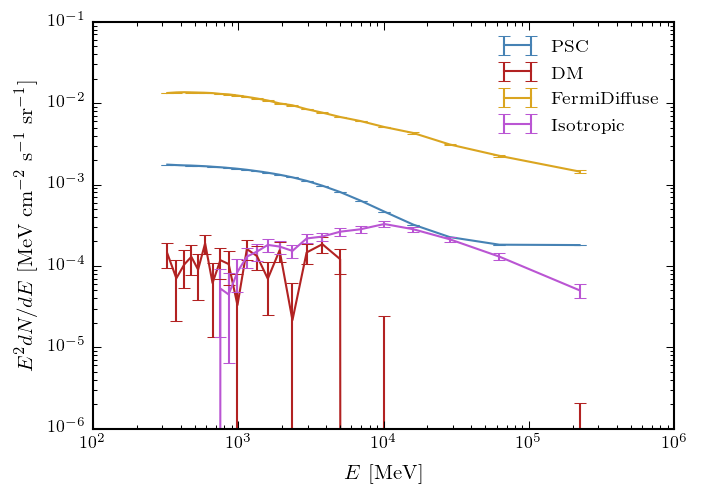

In [52]:
for key in A.templateList.keys():
    # Get the flux and uncertainties averaged over the masked area. 
    E, flux, fluxunc = A.GetSpectrum(key) 
    # Plot the SED 
    plt.errorbar(E, E**2*flux, yerr=E**2*fluxunc.T, label=key)
    
plt.legend(frameon=False)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$E$ [MeV]')
plt.ylabel(r'$E^2 dN/dE \rm\ [MeV\ cm^{-2}\ s^{-1}\ sr^{-1}]$')


## Plot Residuals

Sigma is 30.000000 arcmin (0.008727 rad) 
-> fwhm is 70.644601 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


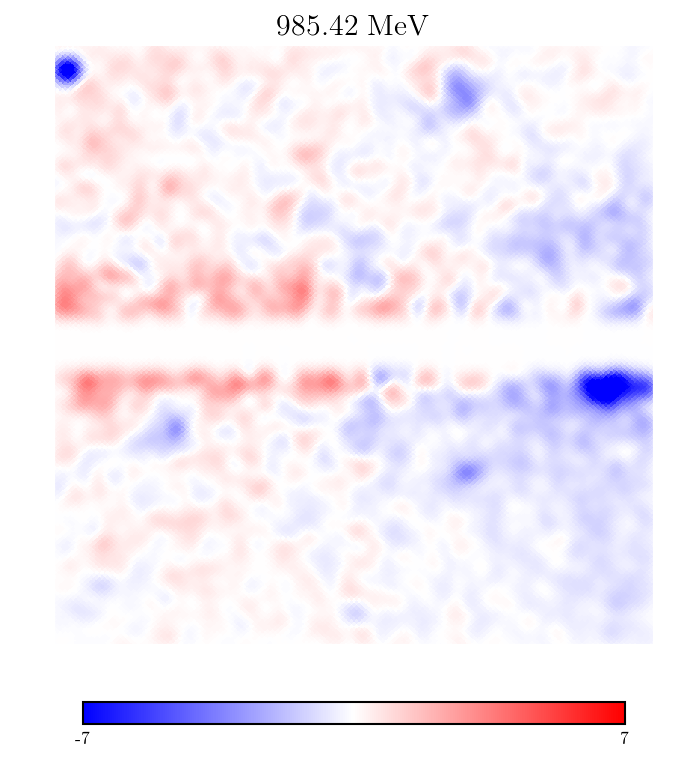

In [65]:
from scipy import ndimage

def PlotResidual(E):
    res = A.GetResidual() # Get the residual emission
    # We can pick the closest bin to the requested energy 
    closest_bin = np.argmin(np.abs(A.central_energies-E))
    
    # Let's smooth it with a .5 deg gaussian 
    smoothed_residual = healpy.smoothing(res[closest_bin]*A.mask, sigma=.5 * np.pi/180)

    healpy.cartview(smoothed_residual, 
                    lonra=(-20,20), latra=(-20,20), 
                    title='%1.2f MeV'%A.central_energies[closest_bin],
                    min=-7, max=7, cmap='bwr')
    
    
PlotResidual(1e3)

# Appendix A: The IGRB flux. 

In [7]:
# Copy this into a file (without the quotes)  Flux and uncertainties from Ackerman 2014 Mod A 
# Columns are energy in MeV, dF/dE in [cm^-2 s^-1 sr^-1 GeV^-1], and flux uncertainty in the same units. 
_ = '''
1.189117319695580761e+02 6.688405797101448344e-08 1.330676328502415173e-08
1.681665840766233941e+02 2.902730375426621627e-08 7.365187713310580518e-09
2.378234639391159533e+02 1.276570048309178518e-08 3.734299516908212025e-09
3.363331681532465041e+02 5.674061433447099126e-09 1.697952218430034233e-09
4.756889740155851314e+02 2.707302353651175919e-09 6.077248038624017140e-10
6.727257985241833467e+02 1.389671361502347637e-09 1.720017072129748487e-10
9.513779480311703765e+02 5.829812914906455811e-10 6.617380808690402529e-11
1.345451597048366693e+03 2.281263337601366040e-10 2.742210840802390362e-11
1.902713851318688512e+03 9.099139882299685566e-11 1.239173079824958667e-11
2.690843733850034369e+03 4.195028272698174583e-11 4.425477435186172238e-12
3.805469747613297386e+03 1.757827235005658283e-11 2.278385514900037671e-12
5.381746928275244500e+03 7.794078420912242388e-12 1.271805814883969075e-12
7.610939495226595682e+03 3.614107883817427282e-12 5.563938136552244640e-13
1.076349385655049082e+04 2.032275273406241870e-12 2.636169645238730183e-13
1.522183694565145925e+04 7.618023727343025250e-13 1.008694996133461180e-13
2.152692825277214433e+04 3.532895000066684028e-13 4.354436457235833891e-14
3.044371593613374353e+04 1.462669395222512070e-13 1.778590895802487582e-14
4.305391596591418056e+04 7.008488873773848392e-14 8.328832163029055183e-15
6.088738982745104295e+04 2.989951762803133528e-14 3.734492660684563219e-15
8.610777247147889284e+04 1.202308592538751474e-14 1.666094297536367510e-15
1.217748216997257405e+05 3.644893965649349302e-15 6.768751989249213691e-16
1.722156044033176440e+05 1.632254999208128737e-15 3.400878560294742413e-16
2.435496013546317117e+05 5.559295021035965411e-16 1.607904666813625147e-16
3.444311493462809012e+05 2.664852866279734120e-16 9.060666454945484253e-17
4.870992447540854919e+05 4.320357133805526964e-17 3.336635980146396416e-17
6.888623581529194489e+05 1.752952115566473410e-19 9.310734726998338704e-18
'''

# Appendix B: All the code together. 

This is useful to initiate an analysis generically. 

In [ ]:
from GammaLike import Analysis

basepath = '/data/GammaLike/testing/'
tag = 'P8R2_CLEAN_V6_calore' 
A = Analysis.Load(basepath+tag+'.GLanalysis')


A.AddFermiDiffuseModel(diffuse_path='/data/fermi_background_models/gll_iem_v06.fits',  # This is the Pass 8 diffuse model.
                       infile=None,       # Won't use this for now, but we can load the result by specifying infile
                       # Store the result by specifying outfile.  
                       # We will need this below to calculate point source masks.
                       outfile=A.basepath+'/'+'fermi_diffuse_'+A.tag+'.npy',
                       fixSpectrum=False) # Allow the spectrum to float in each energy bin. 
A.AddIsotropicTemplate(
        isofile='/data/GCE_sys/IGRB_ackerman_2014_modA.dat', # See the appendix at the bottom of the file. 
        fixNorm=False, fixSpectrum=False) 

A.AddPointSourceTemplate(fixNorm=True, # Fix the template normalization in all bins.
                         pscmap=A.basepath + '/PSC_' + A.tag + '_fgl3_with_ext.npy') # This was generated in the first tutorial

A.CalculatePixelWeights(diffuse_model=A.basepath+'/'+'fermi_diffuse_'+A.tag+'.npy',
                        psc_model=A.basepath + '/PSC_' + A.tag + '_fgl3_with_ext.npy',
                        alpha_psc=5., f_psc=0.1) # see 1409.0042 Eq.(2.6)

_ = A.GenSquareMask(l_range=[-20.,20.], b_range=[-20.,20.], plane_mask=2.)


_ = A.AddDMTemplate(profile='NFW', # Can be 'Ein', 'NFW', or 'Bur'
                limits=[None,None], 
                decay=False,     # Annihilation or decay? 
                gamma=1.25,      # Inner Slope
                r_s=20.0,        # NFW Scale radius 
                axesratio=1,     # Can skew the projected profile 
                offset=(0, 0),   # Can offset the profile 
                spec_file=None,) # Can specify a spectrum if we want 
